In [58]:
% matplotlib inline
import seaborn as sns
import numpy as np
import pylab as pl
import mahotas as mh
import skimage as ski
import skimage.filters as skif
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import pandas as pd
from skimage import segmentation
from skimage import morphology
from pprint import pprint
from sklearn import cluster
from sklearn import decomposition
from sklearn.cluster import KMeans

In [170]:

def labelcells(image,kernelsize):
    '''
    Takes an image and a size for the kernel used to blur the distance matrix. Returns a trimed/blob-labeled image.
    '''
    img2=np.mean(image,2).astype(u'uint8')
    smooth = img2#mh.gaussian_filter(img2,1.5).astype('uint8')
    thresh = mh.thresholding.otsu(smooth)
    mask = smooth>thresh
    inverted = np.invert(smooth>thresh)
    filled = ndi.binary_fill_holes(inverted)
    dist = mh.distance(filled)
    #dist = ndi.morphology.distance_transform_edt(filled)
    dist = dist.max() - dist
    dist -= dist.min()
    dist  = dist/float(dist.ptp()) * 255
    dist = dist.astype(np.uint8)
    smooth2 = mh.gaussian_filter(dist,kernelsize).astype('uint8')
    rmax = mh.regmin(smooth2)
    seeds, ncells = mh.label(rmax)
    nuclei = mh.cwatershed(smooth2,seeds)
    whole = (nuclei*filled)
    return trimedges(whole)
    

def trimedges(whole):
    '''
    Takes a masked/labeled image and returns it with any object touching the edge to 
    '''
    borders = np.zeros(whole.shape,np.bool)
    borders[0:1,:] = 1
    borders[-1:,:] = 1
    borders[:,0:1] = 1
    borders[:,-1:] = 1
    at_border = np.unique(whole[borders])
    for obj in at_border:
        whole[whole==obj] = 0
    return whole

def separatecells(labeled,image):
    cellimages = []
    ylen,xlen = labeled.shape
    x = []
    y = []
    area = []
    for cell in np.unique(labeled)[1:]:
        cellmask = labeled.copy()
        cellmask[cellmask!=cell]=0
        cellmask[cellmask==cell]=1
        xmin = np.nonzero(cellmask.sum(axis = 0))[0].min()-2
        xmax = np.nonzero(cellmask.sum(axis = 0))[0].max()+2
        ymin = np.nonzero(cellmask.sum(axis = 1))[0].min()-2
        ymax = np.nonzero(cellmask.sum(axis = 1))[0].max()+2
        if xmin<0:
            xmin = 0
        if xmax>xlen:
            xmax = xlen
        if ymin<0:
            ymin = 0
        if ymax>ylen:
            ymax = ylen
        #takes care of cells close to edge that aren't touching it. Otherwise the pulled image won't work
        crop = image[ymin:ymax,xmin:xmax]
        cropmask = cellmask[ymin:ymax,xmin:xmax]
        cropmask = ndi.binary_dilation(cropmask,iterations=2)
        crop2 = np.empty(crop.shape)
        crop2[:,:,0] = cropmask*crop[:,:,0]
        crop2[:,:,1] = cropmask*crop[:,:,1]
        crop2[:,:,2] = cropmask*crop[:,:,2]
        crop2 = crop2.astype('uint8')
        cellimages.append((cell,crop2))
    return cellimages

def image2cells(image):
    labeled = labelcells(image,1.9)
    return separatecells(labeled,image)

def channel2vec(img):
    vec =[]
    xavgs = img.mean(0)
    yavgs = img.mean(1)
    y,x = img.shape
    yslice = np.linspace(0,y-1,5).astype('int')
    xslice = np.linspace(0,x-1,5).astype('int')
    slic = 0
    for index in yslice[1:]:
        vec.append(yavgs[slic:index].mean())
        slic = index
    slic = 0
    for index in xslice[1:]:
        vec.append(yavgs[slic:index].mean())
        slic = index
    return vec
    
def cell2vec(image):
    vec = list(image.shape[:2])
    for chan in range(0,3):
        channel = img[:,:,chan]
        vec = vec + channel2vec(channel)
    return vec

def image2vecs(image):
    cells = image2cells(image)
    cellvecs = []
    for cell in cells:
        cellvec = cell2vec(cell[1])
        cellvec.insert(0,cell[0])
        cellvecs.append(cellvec)
        df = pd.DataFrame(cellvecs)
        df = df.set_index(0)
    return df#, cells

def clustercells(df, nclusters):
    km = KMeans(n_clusters=nclusters)
    clusters = km.fit_predict(df)
    df['cluster'] = clusters
    return df



In [171]:
test = image2vecs(img)

In [178]:
test.

[(10, 1),
 (17, 1),
 (19, 0),
 (20, 0),
 (21, 1),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 1),
 (28, 0),
 (29, 0),
 (30, 0),
 (31, 0),
 (32, 0),
 (33, 0),
 (34, 0),
 (35, 0),
 (36, 0),
 (37, 0),
 (38, 0),
 (39, 0),
 (40, 0),
 (41, 0),
 (42, 0),
 (43, 0),
 (44, 0),
 (45, 0),
 (46, 0),
 (47, 1),
 (48, 0),
 (50, 0),
 (51, 1),
 (52, 1),
 (53, 0),
 (54, 0),
 (55, 0),
 (56, 0),
 (57, 0),
 (58, 0),
 (59, 0),
 (61, 1),
 (62, 0),
 (63, 0),
 (64, 0),
 (65, 0),
 (66, 0),
 (67, 0),
 (68, 0),
 (69, 0),
 (70, 1),
 (71, 0),
 (72, 0),
 (73, 0),
 (74, 0),
 (75, 0),
 (76, 0),
 (77, 0),
 (78, 0),
 (79, 0),
 (80, 0),
 (81, 0),
 (82, 0),
 (83, 0),
 (84, 0),
 (85, 0),
 (87, 1),
 (88, 0),
 (89, 0),
 (90, 0),
 (91, 0),
 (93, 0),
 (94, 0),
 (95, 0),
 (96, 0),
 (97, 0),
 (98, 0),
 (99, 0),
 (100, 0),
 (101, 1),
 (102, 0),
 (103, 1),
 (104, 0),
 (105, 0),
 (106, 0),
 (107, 0),
 (108, 0),
 (109, 0),
 (110, 0),
 (111, 0),
 (112, 2),
 (114, 0),
 (116, 0),
 (117, 1),
 (118, 0),
 (119, 0),
 (120, 0),
 (121, 0),


In [151]:
img = mh.imread('blood2.jpg')

In [136]:
def image2vecs(image):
    cells = image2cells(image)
    cellvecs = []#[range(1,len(cells)+1)]
    #i = 1
    #cellids = []
    for cell in cells:
        cellvec = cell2vec(cell)
        #cellvec.insert(0,i)
        cellvecs.append(cellvec)
        #i += 1
        #cellids.append((i,cell))
    df = pd.DataFrame(cellvecs)
    return df, cells

In [174]:



def boxcells(image):
    labeled = labelcells(image,1.5)
    cellimages = []
    ylen,xlen = labeled.shape
    x = []
    y = []
    pl.figure(figsize=(17,17))
    pl.imshow(np.invert(image))
    for cell in np.unique(labeled)[1:]:
        cellmask = labeled.copy()
        cellmask[cellmask!=cell]=0
        cellmask[cellmask==cell]=1
        xmin = np.nonzero(cellmask.sum(axis = 0))[0].min()#-2
        xmax = np.nonzero(cellmask.sum(axis = 0))[0].max()#+2
        ymin = np.nonzero(cellmask.sum(axis = 1))[0].min()#-2
        ymax = np.nonzero(cellmask.sum(axis = 1))[0].max()#+2
        if xmin<0:
            xmin = 0
        if xmax>xlen:
            xmax = xlen
        if ymin<0:
            ymin = 0
        if ymax>ylen:
            ymax = ylen
        plt.plot([xmin,xmin],[ymin,ymax],'r',linewidth=.75)
        plt.plot([xmin,xmax],[ymin,ymin],'r',linewidth=.75)
        plt.plot([xmax,xmax],[ymin,ymax],'r',linewidth=.75)
        plt.plot([xmax,xmin],[ymax,ymax],'r',linewidth=.75)


IndentationError: unexpected indent (<ipython-input-174-ace3d35493a7>, line 30)

In [174]:

def boxclusteredcells(image,nclusters):
    labeled = labelcells(image,1.5)
    ylen,xlen = labeled.shape
    pl.figure(figsize=(17,17))
    pl.imshow(np.invert(image))
    df = image2vecs(image)
    df
    for cell in np.unique(labeled)[1:]:
        cellmask = labeled.copy()
        cellmask[cellmask!=cell]=0
        cellmask[cellmask==cell]=1
        xmin = np.nonzero(cellmask.sum(axis = 0))[0].min()#-2
        xmax = np.nonzero(cellmask.sum(axis = 0))[0].max()#+2
        ymin = np.nonzero(cellmask.sum(axis = 1))[0].min()#-2
        ymax = np.nonzero(cellmask.sum(axis = 1))[0].max()#+2
        if xmin<0:
            xmin = 0
        if xmax>xlen:
            xmax = xlen
        if ymin<0:
            ymin = 0
        if ymax>ylen:
            ymax = ylen
        coordinates = (cell,(xmin,xmax,ymin,ymax,))
        if cluster =
            plotbox(xmin,xmax,ymin,ymax,color)

def plotbox(coordinates, ):
    plt.plot([xmin,xmin],[ymin,ymax],'r',linewidth=.75)
    plt.plot([xmin,xmax],[ymin,ymin],'r',linewidth=.75)
    plt.plot([xmax,xmax],[ymin,ymax],'r',linewidth=.75)
    plt.plot([xmax,xmin],[ymax,ymax],'r',linewidth=.75)

IndentationError: unexpected indent (<ipython-input-174-ace3d35493a7>, line 30)

In [148]:
img = mh.imread('Mouse_Anti_Beta_Tubulin_monoclonal_Antibody01.jpg')

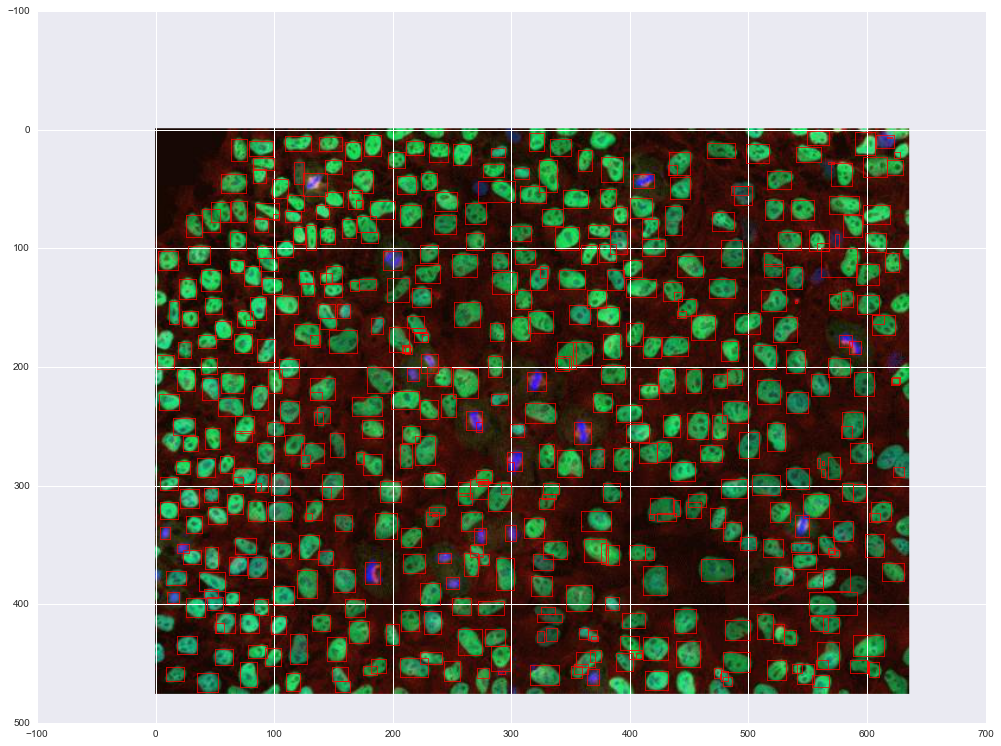

In [149]:
boxcells(np.invert(img))

In [32]:
km = KMeans(n_clusters=3)

In [169]:
def clustercells(df, nclusters):
    km = KMeans(n_clusters=nclusters)
    clusters = km.fit_predict(df)
    df['cluster'] = clusters
    return df

In [172]:
dff = clustercells(test,3)

In [173]:
dff.head()

,1,2,3,4,5,6,7,8,9,10,...,18,19,20,21,22,23,24,25,26,cluster
0,,,,,,,,,,,,,,,,,,,,,
10,15,16,175.9,173.639913,171.8392,171.891739,175.332901,172.532984,172.083642,173.312745,...,158.266176,191.494118,190.113224,189.628447,189.588074,190.960268,189.911739,189.730865,191.079902,1
17,13,14,175.9,173.639913,171.8392,171.891739,175.332901,172.532984,172.083642,173.312745,...,158.266176,191.494118,190.113224,189.628447,189.588074,190.960268,189.911739,189.730865,191.079902,1
19,39,22,175.9,173.639913,171.8392,171.891739,175.332901,172.532984,172.083642,173.312745,...,158.266176,191.494118,190.113224,189.628447,189.588074,190.960268,189.911739,189.730865,191.079902,0
20,36,73,175.9,173.639913,171.8392,171.891739,175.332901,172.532984,172.083642,173.312745,...,158.266176,191.494118,190.113224,189.628447,189.588074,190.960268,189.911739,189.730865,191.079902,0
21,7,15,175.9,173.639913,171.8392,171.891739,175.332901,172.532984,172.083642,173.312745,...,158.266176,191.494118,190.113224,189.628447,189.588074,190.960268,189.911739,189.730865,191.079902,1


In [168]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,18,19,20,21,22,23,24,25,26,cluster
0,,,,,,,,,,,,,,,,,,,,,
10,15,16,175.9,173.639913,171.8392,171.891739,175.332901,172.532984,172.083642,173.312745,...,158.266176,191.494118,190.113224,189.628447,189.588074,190.960268,189.911739,189.730865,191.079902,1
17,13,14,175.9,173.639913,171.8392,171.891739,175.332901,172.532984,172.083642,173.312745,...,158.266176,191.494118,190.113224,189.628447,189.588074,190.960268,189.911739,189.730865,191.079902,1
19,39,22,175.9,173.639913,171.8392,171.891739,175.332901,172.532984,172.083642,173.312745,...,158.266176,191.494118,190.113224,189.628447,189.588074,190.960268,189.911739,189.730865,191.079902,0
20,36,73,175.9,173.639913,171.8392,171.891739,175.332901,172.532984,172.083642,173.312745,...,158.266176,191.494118,190.113224,189.628447,189.588074,190.960268,189.911739,189.730865,191.079902,0
21,7,15,175.9,173.639913,171.8392,171.891739,175.332901,172.532984,172.083642,173.312745,...,158.266176,191.494118,190.113224,189.628447,189.588074,190.960268,189.911739,189.730865,191.079902,1


In [167]:
df['cluster'] = clusters

In [51]:
clusters = km.fit_predict(test.ix[:,:1])

In [73]:
clusters[90]

2

In [164]:
clusters

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1], dtype=int32)

In [70]:
clusters[clusters==3]=1

In [34]:
clusters

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1], dtype=int32)

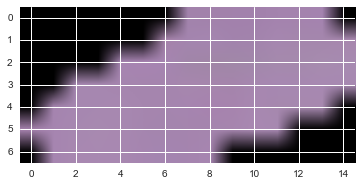

In [72]:
pl.imshow(cells[4])

AttributeError: 'Figure' object has no attribute 'add_patch'

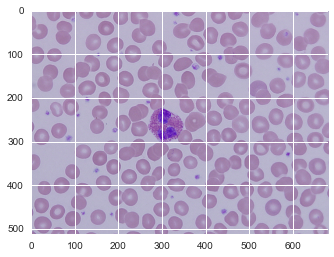

In [64]:
fig = plt.figure()
pl.imshow(img)
fig.add_patch(patches.Rectangle((0.1, 0.1),0.5,0.5,fill=False))